# Creating Activation Atlases with captum.optim

This notebook demonstrates the use of the captum.optim submodule for creation of [Activation Atlases](https://distill.pub/2019/activation-atlas/) for the InceptionV1 model imported from Caffe.

Activation atlases provide a big picture overview of how a model layer represents various concepts, by using samples from the manifold of likely activations. Activation atlases can also show us the relationships between concepts, and they make it possible to identify possible adversarial attacks.


In [ ]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
import matplotlib.pyplot as plt

from captum.optim.models import googlenet

import captum.optim as opt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = googlenet(pretrained=True).to(device).eval()

We'll begin by defining some helper functions that will be explained in greater detail later on in the tutorial.

In [ ]:
from typing import List, Optional, Tuple, Union


def create_alpha_mask(
    h: int,
    w: int,
    coords: List[Union[Tuple[int, int, int], Tuple[int, int]]],
    device: torch.device = torch.device("cpu"),
) -> torch.tensor:
    """
    Create an alpha mask to make an activation atlas background transparent.

    Args:
       h (int): The height of each cell.
       w (int): the width of each cell.
       coords (List[Union[Tuple[int, int, int], Tuple[int, int]]]): A list of
           atlas coordinates to use for creating the mask.
       device (torch.device, optional): The device that the cells are on.
    Returns:
       alpha_mask (torch.Tensor): An alpha mask tensor used to make an atlas
           background transparent.
    """

    return opt.atlas.create_atlas(
        [torch.ones(1, 1, h, w, device=device) for n in coords],
        coords,
        grid_size=grid_size,
        base_tensor=torch.zeros,
    )


def extract_grid_attributions(
    grid_indices: List[List[torch.Tensor]],
    raw_attributions: torch.Tensor,
    grid_size: Tuple[int, int],
    target_class_ids: Union[int, List[int]],
    min_density: int = 8,
) -> torch.Tensor:
    """
    Collect cell attributions for the specific grid indices. Grid cells
    without the minimum number of indices as specified by min_density will be
    ignored.

    Args:
        grid_indices (list of list of torch.tensor): List of lists of grid indices to
            use.
        raw_attributions (torch.tensor): Sample attributions, with a shape
            of: [n_samples, n_classes].
        grid_size (Tuple[int, int]): The grid_size of grid cells to use. The grid_size
            variable should be in the format of: [width, height].
        target_class_ids (int or list of int): The target classes to extract cell
            attributions for.
        min_density (int, optional): The minimum number of points for a cell to be
            counted.
    Returns:
        cell_attributions (torch.tensor): A tensor containing all the cell attributions.
    """

    assert raw_attributions.dim() == 2
    average_attributions: List[torch.Tensor] = []
    for x in range(grid_size[0]):
        for y in range(grid_size[1]):
            indices = grid_indices[x][y]
            if len(indices) >= min_density:
                average_attributions.append(
                    torch.mean(raw_attributions[indices][:, target_class_ids], 0)
                )
    return torch.stack(average_attributions)

## Atlas Setup

Activation atlases are created by using randomly collected neuron activation samples from the dataset that the selected model was trained on.

Samples are collected by first randomly collecting a neuron activation sample with a shape of: `1, channels, 1, 1` for every image in the batch. We avoid edge neurons to improve activation atlas quality by only collecting neuron samples from between `[..., 1 : height -1, 1 : width -1]`. The neuron class attributions are then estimated by determining the rate at which increasing the neuron affects the output classes.

### Download Pre-collected Activations & Attributions

Before we can start the main tutorial, you'll first have to download a set of pre-collected activation and attribution samples for Mixed4c ReLU layer of our model. For this tutorial we'll use the recommended number of 100,000 activation & attribution samples, but in practice any number of samples can be used (though more samples is always better). The sample attributions were collected using a relaxed version of our model where all of the `nn.MaxPool2d` layers were replaced with Captum's `MaxPool2dRelaxed` layer.

Activation samples have a shape of `[n_samples, n_channels]`. The corresponding attribution samples have a shape of `[n_samples, n_features]`, where `n_features` is the number of output classes from the final main FC layer (also called logits).

You can learn more about how to collect your own samples from the Atlas Sample Collection tutorial.

In [ ]:
fileurl = "https://pytorch-tutorial-assets.s3.amazonaws.com/captum/"

activation_samples = torch.hub.load_state_dict_from_url(
    url=fileurl + "inceptionv1_mixed4c_relu_samples_activations.pt",
    progress=True,
).to(device)

sample_attributions = torch.hub.load_state_dict_from_url(
    url=fileurl + "inceptionv1_mixed4c_relu_samples_attributions.pt",
    progress=True,
).to(device)

### Dimensionality Reduction For Activation Atlas Coordinate Grid Creation

After loading our dataset activation samples for the Mixed4c ReLU layer, we can use either [UMAP](https://umap-learn.readthedocs.io/en/latest/) or Sklearn's [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to reduce the number of channels to 2. By reducing the number of channels in our activation samples to 2, we turn the data in a grid of x and y coordinates that we can then graph and visualize!

In general t-SNE performs better than UMAP on sparse sample data like the y axis of multi class activation atlases. The UMAP alogrithm performs better on dense sample data for more general activation atlases.

**Reproducibility**

It is important to note that by default both UMAP and t-SNE introduce a bit of randomness into their results, and thus individual cells and the overall shape of the atlas will differ between runs. This is acceptable as we are mainly interested in the spatial relationships that emerge between concepts in the atlas.

If you would like to recreate the same atlas shape at any point in the future, you can use `torch.save` to save the `xy_grid` variable after it has been created. Then afterwards, you can skip the dimensionality reduction step and simply reload the saved variable with `torch.load`.

In [ ]:
import umap

c_reducer = opt.reducer.ChannelReducer(
    n_components=2,
    reduction_alg=umap.UMAP,
    verbose=True,
    n_neighbors=20,
    min_dist=0.01,
    metric="cosine",
)
# You can also use TSNE instead of UMAP if desired:
# from sklearn.manifold import TSNE
# c_reducer = opt.reducer.ChannelReducer(
#    n_components=2,
#    reduction_alg=TSNE,
#    verbose=True,
#    metric="cosine",
#    learning_rate=10,
#    perplexity=50,
# )

xy_grid = c_reducer.fit_transform(activation_samples.to("cpu")).to(device)

UMAP(a=None, angular_rp_forest=True, b=None, dens_frac=0.0, dens_lambda=0.0,
     dens_var_shift=0.1, densmap=False, disconnection_distance=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=True, metric='cosine', metric_kwds=None,
     min_dist=0.01, n_components=2, n_epochs=None, n_jobs=-1, n_neighbors=20,
     negative_sample_rate=5, output_dens=False, output_metric='euclidean',
     output_metric_kwds=None, random_state=None, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, ...)
Construct fuzzy simplicial set
Sat May  1 18:36:53 2021 Finding Nearest Neighbors
Sat May  1 18:36:53 2021 Building RP forest with 21 trees
Sat May  1 18:37:01 2021 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	 5  /  17
	 6  /  17
	Stopping threshold met -- exiting after 6 iterations
Sat May  1 18:37:32 2021 Finished Nearest Neighbor S

Now that we have our two dimensional grid of x and y coordinates for our reduced activation samples, we need to normalize it. We can use Captum.optim's `normalize_grid` function to both remove outliers and to rescale the values of our graph to between 0 and 1.

In [ ]:
# Normalize xy_grid for graphing
normalized_xy_grid = opt.atlas.normalize_grid(xy_grid)

After normalizing the xy grid, it is possible to plot the results using a graphing library like `matplotlib`. The shape of the plotted graph will be the same shape as the full activation atlas!

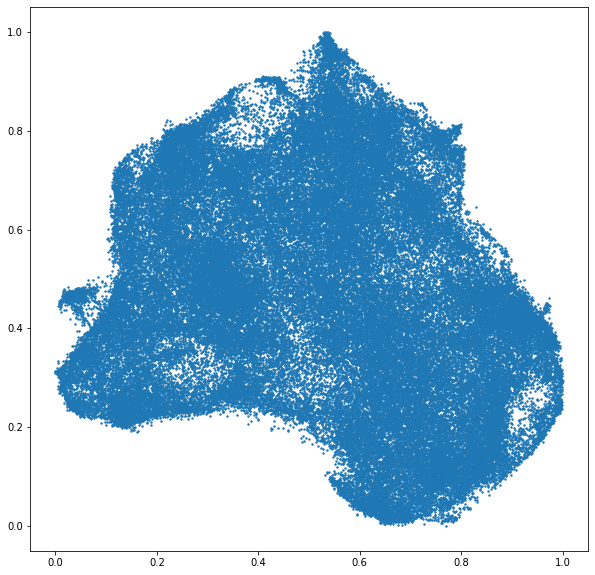

In [ ]:
# Show the normalized xy coordinate grid
plt.figure(figsize=(10, 10))
plt.scatter(x=normalized_xy_grid[:, 0].cpu(), y=normalized_xy_grid[:, 1].cpu(), s=2)
plt.show()

## Activation Atlas Vectors & Coordinates

Now we can use both the raw activation samples and our xy coordinate grid to create the direction vectors that are required for rendering the atlas visualizations. To create the direction vectors we will used Captum.optim's `create_atlas_vectors` function:

* The `xy_grid` parameter is for the xy coordinate grid tensor, and requires a shape of `[n_points, 2]`.
* The `raw_activations` parameter is for the raw activation samples (that can optionally be filtered beforehand).
* The `grid_size` parameter defines how big our atlas should be, with the number of visualizations for each dimension in the form of: (`width, height`).
* The `min_density` parameter specifies the minimum number of sample points a cell requires to be counted.
* The `normalize` parameter determines whether `xy_grid` requires normalization.

The `create_atlas_vectors` function will return a set of direction vectors and a list of corresponding coordinations for creating the final activation atlas image. Each set of coordinates will also contain the number of samples that were used to create the direction at that position.

While choosing a `grid_size` is completely arbitrary, choosing the wrong grid size can result in important concepts being hidden in the averages.

In [ ]:
grid_size = (20, 20)
min_density = 8
vecs, vec_coords = opt.atlas.create_atlas_vectors(
    xy_grid=normalized_xy_grid,
    raw_activations=activation_samples,
    grid_size=grid_size,
    min_density=min_density,
    normalize=False, # Don't run normalize_grid as we already did it above
)

### Activation Atlas Heatmap & Shape

Using the atlas coordinates we created above, we can easily see the shape of our atlas before rendering all of the images. We'll explain the `create_atlas` function in greater detail further down.

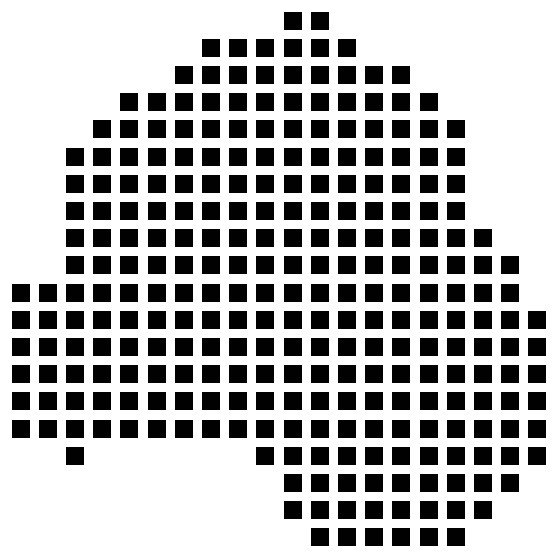

In [ ]:
import torch.nn.functional as F

# Create black & white atlas
atlas_bw_tensors = [
    F.pad(torch.ones(1, 3, 4, 4) * 255, (1, 1, 1, 1), value=1) for n in vec_coords
]
atlas_bw = opt.atlas.create_atlas(
    atlas_bw_tensors, vec_coords, grid_size=grid_size
)

# Make background transparent
alpha_bw_mask = create_alpha_mask(6, 6, coords=vec_coords, device=atlas_bw.device)
atlas_bw = torch.cat([atlas_bw, alpha_bw_mask], 1)

opt.images.show(atlas_bw, figsize=(10, 10))

We can also see which atlas cells have the most samples like so (the darker the color, the more activation samples used):

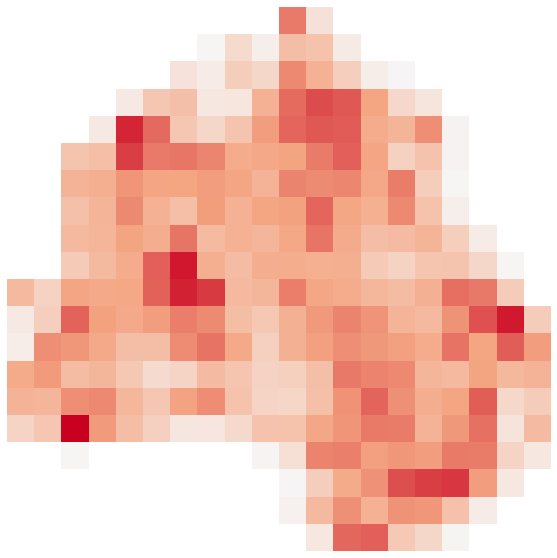

In [ ]:
# Create heatmap atlas
atlas_hm_tensors = [torch.ones(1, 1, 1, 1) * n[2] for n in vec_coords]
atlas_hm = opt.atlas.create_atlas(
    atlas_hm_tensors, vec_coords, grid_size=grid_size
)
atlas_hm = atlas_hm / atlas_hm.max()
atlas_hm = opt.weights_to_heatmap_2d(atlas_hm[0, 0])

# Make background transparent
alpha_hm_mask = create_alpha_mask(1, 1, coords=vec_coords, device=atlas_hm.device)
atlas_hm = torch.cat([atlas_hm.unsqueeze(0), alpha_hm_mask], 1)

opt.images.show(atlas_hm, figsize=(10, 10))

## Rendering The Activation Atlas Visualizations

Now we should have everything we need to start rendering the visualizations for each activation atlas cell!

To create the visualizations for our atlas we will use the `AngledNeuronDirection` objective, which places more emphasis on angle than the default direction objectives. We'll also make use of Captum.optim's batch targeting feature to greatly speed up rendering!

In [ ]:
def vis_neuron_direction(
    model: torch.nn.Module,
    target: torch.nn.Module,
    vecs: torch.Tensor,
    vec_whitened: Optional[torch.Tensor] = None,
) -> Tuple[torch.Tensor, torch.Tensor]:
    image = opt.images.NaturalImage((80, 80), batch=vecs.shape[0]).to(device)

    # Put each direction vector in its own objective using batch targeting
    loss_fn_list = [
        opt.loss.AngledNeuronDirection(
            target, vec, vec_whitened, cossim_pow=4.0, batch_index=i
        )
        for i, vec in enumerate(vecs)
    ]
    # Combine list of batch objectives into a single objective
    loss_fn = sum(loss_fn_list)

    transforms = torch.nn.Sequential(
        torch.nn.ConstantPad2d(2, value=1.0),
        opt.transforms.RandomSpatialJitter(4),
        opt.transforms.RandomSpatialJitter(4),
        opt.transforms.RandomSpatialJitter(8),
        opt.transforms.RandomSpatialJitter(8),
        opt.transforms.RandomSpatialJitter(8),
        opt.transforms.RandomScale(
            scale=[0.995 ** n for n in range(-5, 80)]
            + [0.998 ** n for n in 2 * list(range(20, 40))]
        ),
        opt.transforms.RandomRotation(
            degrees=list(range(-20, 20))
            + list(range(-10, 10))
            + list(range(-5, 5))
            + 5 * [0]
        ),
        opt.transforms.RandomSpatialJitter(2),
    )
    obj = opt.InputOptimization(model, loss_fn, image, transforms)
    history = obj.optimize(opt.optimization.n_steps(512, True), lr=0.0125)

    # Collect the final loss values separately for each batch element
    final_activations = opt.models.collect_activations(model, target, image().detach())
    final_losses = torch.stack([l(final_activations).mean() for l in loss_fn_list])

    return image(), final_losses

Next we whiten the raw Mixed4c ReLU activation samples to help unstretch the activation space for the `AngledNeuronDirection` objective.

In [ ]:
# Whiten the raw activations
whitend_activation_samples = torch.inverse(
    torch.matmul(activation_samples.T, activation_samples)
    / len(activation_samples)
)

Now we can render all the previously calculated direction vectors! To maximize atlas quality, we can optionally try rendering multiple attempts of each atlas cell visualization and then keeping the attempt with the lowest final loss value (closest to zero).

In [ ]:
num_attempts = 2

attempts, attempt_losses = [], []
for a in range(num_attempts):
    if num_attempts > 1:
        print("Attempt: {} / {} ".format(a + 1, num_attempts))

    imgs, losses = vis_neuron_direction(
        model, model.mixed4c_relu, vecs=vecs, vec_whitened=whitend_activation_samples
    )
    attempts.append(imgs.detach().cpu())
    attempt_losses.append(losses)

A = []
attempt_losses = torch.stack(attempt_losses)
for i in range(vecs.shape[0]):
    idx = torch.argmax(attempt_losses[:,i])
    A.append(attempts[idx][i].unsqueeze(0))

Attempt: 1 / 2 



Attempt: 2 / 2 


Now we can put all the newly rendered images together using the cell coordinates that we previously calculated!

To put the rendered atlas cells together, we'll use the `create_atlas` function. The `create_atlas` takes the following inputs and returns a complete atlas in the form of a tensor:

* `cells`: A list of NCHW image tensors that are all the same shape, or a set of NCHW image tensors stacked along the batch dimension.

* `coords`: A list of coordinates that correspond to the inputs to `cells`.

* `grid_size` The same grid size that was used to create the atlas visualizations and coordinates.

The resulting atlas will match the number of channels used in the input cells. Thus, this flexibility of the `create_atlas` function allows us to do things like create a alpha transparency mask in order to make the background transparent!

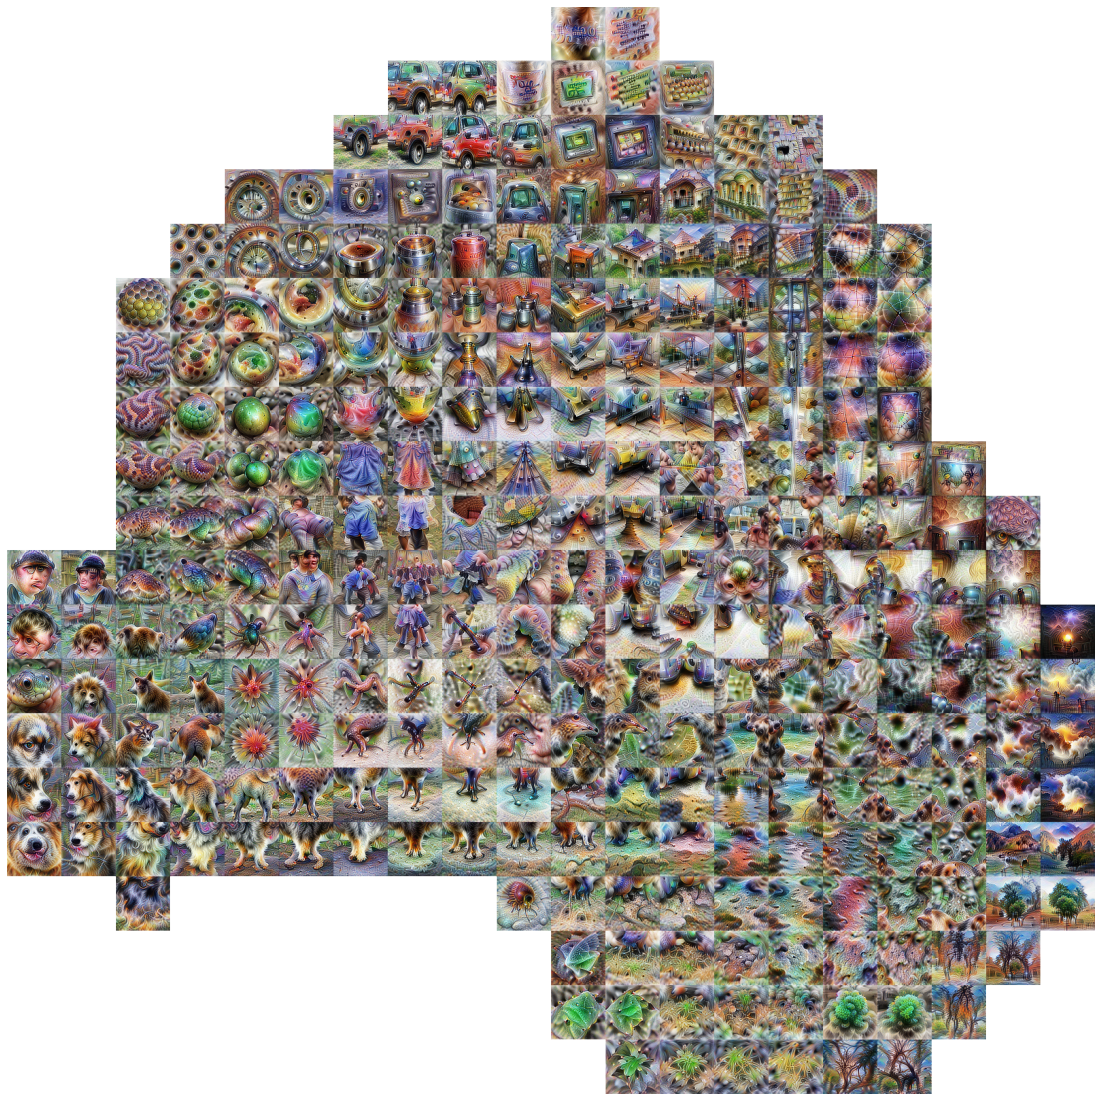

In [ ]:
atlas_img_rgb = opt.atlas.create_atlas(A, vec_coords, grid_size=grid_size)

# Make background transparent
alpha_mask = create_alpha_mask(
    *A[0].shape[2:], coords=vec_coords, device=atlas_img_rgb.device
)
atlas_img = torch.cat([atlas_img_rgb, alpha_mask], 1)

# Save atlas as image and show it to user
opt.images.save_tensor_as_image(atlas_img.detach(), "atlas.png")
opt.images.show(atlas_img.detach(), figsize=(20, 20))

Looking at the full activation atlas, we can see that concepts are grouped together based on similarity! It is also possible to trace paths of how a concept changes across the atlas!

## Class Filtering of Activation Atlases

Now that we have the full activation atlas, we can visualize what parts of our newly created atlas correspond most strongly to a target class like so:

In [ ]:
# Uncomment to print all 1000 model class ids and their corresponding classnames
# {print(str(v) + ":", k) for v, k in enumerate(opt.models.INCEPTION5H_CLASSES)}

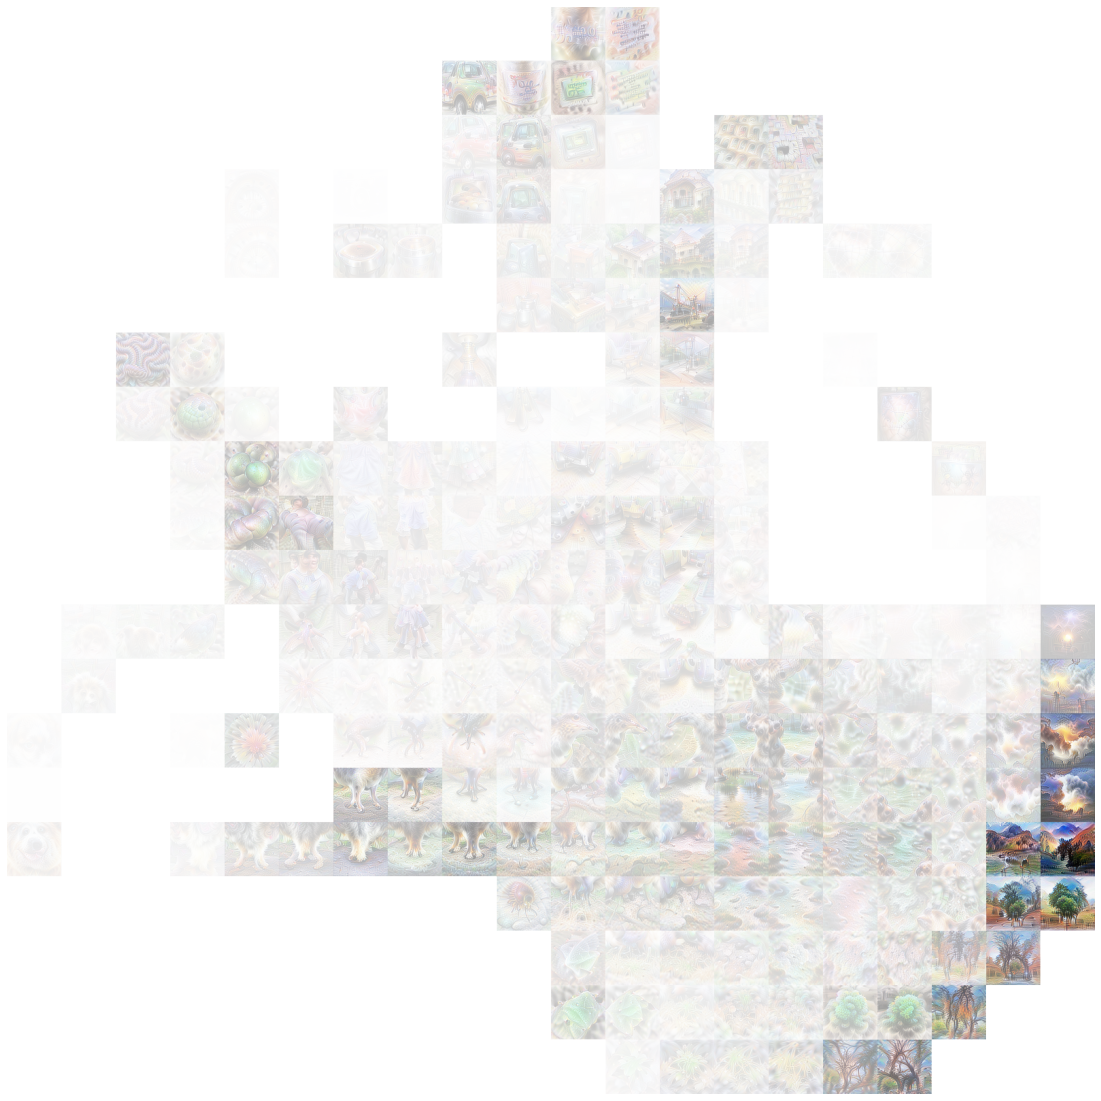

In [ ]:
class_id = 366  # lakeside

# Extract attributions corresponding to our atlas cells
indices = opt.atlas.calc_grid_indices(
    opt.atlas.normalize_grid(xy_grid), grid_size=grid_size
)

# Create vectors for attribution indices
cell_attrs = (
    extract_grid_attributions(
        grid_indices=indices,
        raw_attributions=sample_attributions,
        grid_size=grid_size,
        target_class_ids=class_id,
        min_density=min_density,
    )
)

# Remove negative values and rescale to between 0 and 1
cell_attrs = torch.nn.functional.relu(cell_attrs) / cell_attrs.max()

# Create attribution transparency mask
class_mask = opt.atlas.create_atlas(
    [
        torch.ones(1, 1, *A[0].shape[2:], device=A[0].device) * attr_val
        for attr_val in cell_attrs.cpu()
    ],
    coords=vec_coords,
    grid_size=grid_size,
    base_tensor=torch.zeros,
)

# Make background transparent & set cell transparency
# based on attribution strength
alpha_mask = create_alpha_mask(
    *A[0].shape[2:], coords=vec_coords, device=atlas_img_rgb.device
) * class_mask
atlas_img = torch.cat([atlas_img_rgb, alpha_mask], 1)

# Save atlas as image and show it to user
opt.images.save_tensor_as_image(atlas_img.detach(), "atlas_class_" + str(class_id) +".png")
opt.images.show(atlas_img.detach(), figsize=(20, 20))